# Proyecto
Preparar un prototipo de un modelo de machine learning para Zyfra. La empresa desarrolla soluciones de eficiencia para la industria pesada.

El modelo debe predecir la cantidad de oro extraído del mineral de oro. Dispones de los datos de extracción y purificación. El modelo ayudará a optimizar la producción y a eliminar los parámetros no rentables.

# 1. Preparacion de datos

# 1.1 Lectura y verificacion de datos

1.1.1 Importar librerias

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

1.1.2 Lectura de datos

In [41]:
gold_recovery_train= pd.read_csv("/datasets/gold_recovery_train.csv")
gold_recovery_test= pd.read_csv("/datasets/gold_recovery_test.csv")
gold_recovery_full= pd.read_csv("/datasets/gold_recovery_full.csv")

1.1.3 Verificacion de los conjuntos de datos disponibles: 

Conjunto de datos: gold_recovery_full

In [42]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


Conjunto de datos: gold_recovery_train

In [43]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


Conjunto de datos: gold_recovery_test

In [44]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

1.1.4 Transformacion del tipo de dato de la variable date tipo object a date tipo datetime en el conjunto de datos full, train y test.

In [45]:
# Verificacion de formato
print(gold_recovery_train["date"].head(2)) # format="%Y-%m-%d %H:%M:%S

gold_recovery_full["date"]= pd.to_datetime(gold_recovery_full["date"],format="%Y-%m-%d %H:%M:%S")
gold_recovery_train["date"]= pd.to_datetime(gold_recovery_train["date"],format="%Y-%m-%d %H:%M:%S")
gold_recovery_test["date"]= pd.to_datetime(gold_recovery_test["date"],format="%Y-%m-%d %H:%M:%S")

0    2016-01-15 00:00:00
1    2016-01-15 01:00:00
Name: date, dtype: object


1.1.5 Verificacion y eliminacion de las columnas no necesarias para la creacion del modelo y el analisis de datos.

Para la creacion y verificacion del modelo solo se utilizaran las columnas que reflejen concentracion de los minerales durante todo el proceso de Mezcla de mineral y la fecha correspondiente. El resto de columnas seran eliminadas de los conjuntos de datos.

gold_recovery_train

In [46]:
cols_included= ["date","rougher.output.recovery","final.output.recovery","rougher.input.feed_size",
                "final.output.concentrate_au","final.output.tail_au","primary_cleaner.output.concentrate_au","primary_cleaner.output.tail_au","rougher.input.feed_au","rougher.output.concentrate_au","rougher.output.tail_au","secondary_cleaner.output.tail_au",
                "final.output.concentrate_ag","final.output.tail_ag","primary_cleaner.output.concentrate_ag","primary_cleaner.output.tail_ag","rougher.input.feed_ag","rougher.output.concentrate_ag","rougher.output.tail_ag","secondary_cleaner.output.tail_ag",
                "final.output.concentrate_pb","final.output.tail_pb","primary_cleaner.output.concentrate_pb","primary_cleaner.output.tail_pb","rougher.input.feed_pb","rougher.output.concentrate_pb","rougher.output.tail_pb","secondary_cleaner.output.tail_pb"]

cols_not_included=[]
for col in gold_recovery_train.columns:
    if col not in cols_included:
        cols_not_included.append(col)

# Se remueven las columnas no necesarias
gold_recovery_train.drop(cols_not_included,axis=1,inplace=True)
# Se remueven los valores en 0 que pueden causar una division por cero en el calculo de la recuperacion
gold_recovery_train= gold_recovery_train[(gold_recovery_train != 0).all(axis=1)]
# Se eliminan valores ausentes y se restablece el indice
gold_recovery_train.dropna(inplace=True)
gold_recovery_train.reset_index(drop=True,inplace=True)

gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12620 entries, 0 to 12619
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   date                                   12620 non-null  datetime64[ns]
 1   final.output.concentrate_ag            12620 non-null  float64       
 2   final.output.concentrate_pb            12620 non-null  float64       
 3   final.output.concentrate_au            12620 non-null  float64       
 4   final.output.recovery                  12620 non-null  float64       
 5   final.output.tail_ag                   12620 non-null  float64       
 6   final.output.tail_pb                   12620 non-null  float64       
 7   final.output.tail_au                   12620 non-null  float64       
 8   primary_cleaner.output.concentrate_ag  12620 non-null  float64       
 9   primary_cleaner.output.concentrate_pb  12620 non-null  float6

gold_recovery_full

In [47]:
gold_recovery_full.drop(cols_not_included,axis=1,inplace=True)
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   date                                   22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag            22627 non-null  float64       
 2   final.output.concentrate_pb            22629 non-null  float64       
 3   final.output.concentrate_au            22630 non-null  float64       
 4   final.output.recovery                  20753 non-null  float64       
 5   final.output.tail_ag                   22633 non-null  float64       
 6   final.output.tail_pb                   22516 non-null  float64       
 7   final.output.tail_au                   22635 non-null  float64       
 8   primary_cleaner.output.concentrate_ag  22618 non-null  float64       
 9   primary_cleaner.output.concentrate_pb  22268 non-null  float6

gold_recovery_test

In [48]:
cols_not_included=[]
for col in gold_recovery_test.columns:
    if col not in cols_included:
        cols_not_included.append(col)

gold_recovery_test.drop(cols_not_included,axis=1,inplace=True)
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     5856 non-null   datetime64[ns]
 1   rougher.input.feed_ag    5840 non-null   float64       
 2   rougher.input.feed_pb    5840 non-null   float64       
 3   rougher.input.feed_size  5834 non-null   float64       
 4   rougher.input.feed_au    5840 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 228.9 KB


# 1.2 Comprueba que el cálculo de la recuperación sea correcto. Calcula la recuperación de la característica rougher.output.recovery mediante el conjunto de entrenamiento. Encuentra el EAM entre tus cálculos y los valores de la característica. Facilita los resultados.

1.2.1 Calcula la recuperación de la característica rougher.output.recovery mediante el conjunto de entrenamiento.

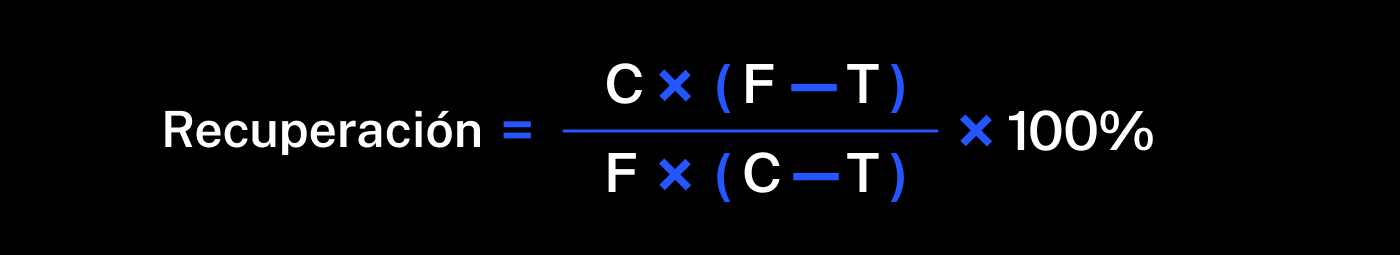

Al reemplazar los valores de la formula, se estan generando multiples divisiones por 0, que causan error en los calculos y no permite realizar la verificacion correspondiente.

Se utilizaran solo las observaciones donde no exista ninguna valor ausente.

-------------------------------------------------------------------------------------------------------------------------------

- RECUPERACION ROUGHER TRAIN

"rougher.output.recovery"

In [49]:
gold_recovery_train_no_missing_values= gold_recovery_train


c= gold_recovery_train_no_missing_values["rougher.output.concentrate_au"]
f= gold_recovery_train_no_missing_values["rougher.input.feed_au"]
t= gold_recovery_train_no_missing_values["rougher.output.tail_au"]

num_recovery = (c*(f-t))
den_recovery = (f*(c-t))

rougher_output_recovery_manual= (num_recovery/den_recovery)*100

Encuentra el EAM entre tus cálculos y los valores de la característica. Facilita los resultados.

In [50]:
temp=0
for i in range(len(rougher_output_recovery_manual)):
    temp  += abs(rougher_output_recovery_manual.loc[i] - gold_recovery_train_no_missing_values["rougher.output.recovery"].loc[i])     
eam= temp / len(rougher_output_recovery_manual)
print(f'Error absoluto medio del calculo manual y los valores dados en el conjunto de datos de la columna "rougher.output.recovery":  {eam}')

Error absoluto medio del calculo manual y los valores dados en el conjunto de datos de la columna "rougher.output.recovery":  9.54278037115526e-15


El error medio de "rougher.output.recovery" entre los valores calculados y el valor dado por el conjunto de datos es 9.460144184559453e-15, lo que significa que los calculos de este variable son correctos.

-------------------------------------------------------------------------------------------------------------------------------

- RECUPERACION FINAL TRAIN

"final.output.recovery"

In [51]:
c= gold_recovery_train_no_missing_values["final.output.concentrate_au"]
f= gold_recovery_train_no_missing_values["rougher.output.concentrate_au"]
t= gold_recovery_train_no_missing_values["secondary_cleaner.output.tail_au"]
        
num_recovery = (c*(f-t))
den_recovery = (f*(c-t))

final_output_recovery_manual= (num_recovery/den_recovery)*100

In [52]:
temp=0
for i in range(len(final_output_recovery_manual)):
    temp += abs(final_output_recovery_manual[i] - gold_recovery_train_no_missing_values["final.output.recovery"][i])    
eam= temp / len(final_output_recovery_manual)
print('Error absoluto medio del calculo manual y los valores dados en el conjunto de datos de la columna "final.output.recovery":  ','\n',eam)

Error absoluto medio del calculo manual y los valores dados en el conjunto de datos de la columna "final.output.recovery":   
 20.195322769078167


El error medio de "final.output.recovery" entre los valores calculados y el valor dado por el conjunto de datos es 20.195322769078167, lo que significa que los calculos de este variable son incorrectos, los datos "final.output.recovery", se reemplazaran por los valores correctos.

In [53]:
gold_recovery_train_no_missing_values["final.output.recovery"]= final_output_recovery_manual

# 1.3. Analiza las características no disponibles en el conjunto de prueba. ¿Cuáles son estos parámetros? ¿Cuál es su tipo?

gold_recovery_test

En el conjunto de datos de prueba existen columnas ausentes, necesarias para el posterior analisis de predicciones del modelo. Estas columnas faltantes se obtendran mediante la union del conjunto de datos full al conjunto de prueba mediante la columna de fecha.

In [54]:
gold_recovery_test_full= gold_recovery_test.merge(gold_recovery_full, on="date",how="left")

- Se eliminaran las observaciones con valores ausentes y con valores en 0

In [55]:
#Eliminar observaciones con valores en 0 que pueden generar division por 0
gold_recovery_test_full= gold_recovery_test_full[(gold_recovery_test_full != 0).all(axis=1)]
# Eliminacion de las observaciones con valores ausentes
gold_recovery_test_full.dropna(inplace=True)
# Reset del indice
gold_recovery_test_full.reset_index(drop=True,inplace=True)

- Se reemplaza el calculo erroneo de la columna "final.output.recovery", por el calculado manualmente.

In [56]:
c= gold_recovery_test_full["final.output.concentrate_au"]
f= gold_recovery_test_full["rougher.output.concentrate_au"]
t= gold_recovery_test_full["secondary_cleaner.output.tail_au"]
        
num_recovery = (c*(f-t))
den_recovery = (f*(c-t))

final_output_recovery_test_manual= (num_recovery/den_recovery)*100
gold_recovery_test_full["final.output.recovery"]= final_output_recovery_test_manual


# 2. Analisis de datos

Conjunto de datos despues del preprocesamiento:

- Conjunto de entrenamiento: gold_recovery_train_no_missing_values

- Conjunto de prueba: gold_recovery_test_full

# 2.1. Observa cómo cambia la concentración de metales (Au, Ag, Pb) en función de la etapa de purificación.

- Antes de la purificacion

["rougher.output.concentrate_au"],
["rougher.output.concentrate_ag"],
["rougher.output.concentrate_pb"]

- Despues de la purificacion

["final.output.concentrate_au"],
["final.output.concentrate_ag"],
["final.output.concentrate_pb"]

- Cambios de concentracion despues de la purificacion

Au

--------------------------------------------------------------------------------------------------------------------

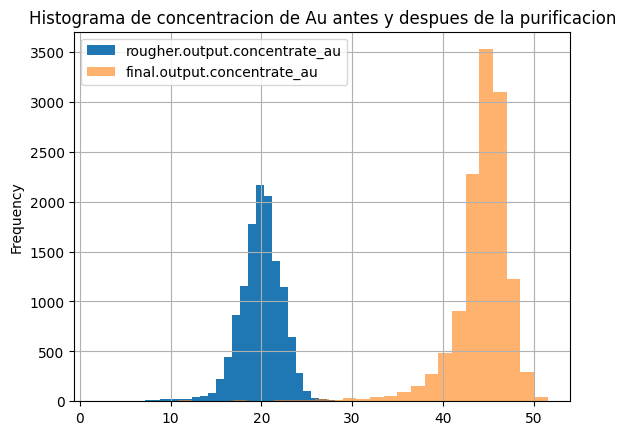

In [57]:
gold_recovery_train_no_missing_values["rougher.output.concentrate_au"].plot(kind="hist",bins=30,legend=True,title="Histograma de concentracion de Au antes y despues de la purificacion")
gold_recovery_train_no_missing_values["final.output.concentrate_au"].plot(kind="hist",bins=30,alpha=0.6,grid=True,legend=True)
plt.show()

Ag

--------------------------------------------------------------------------------------------------------------------

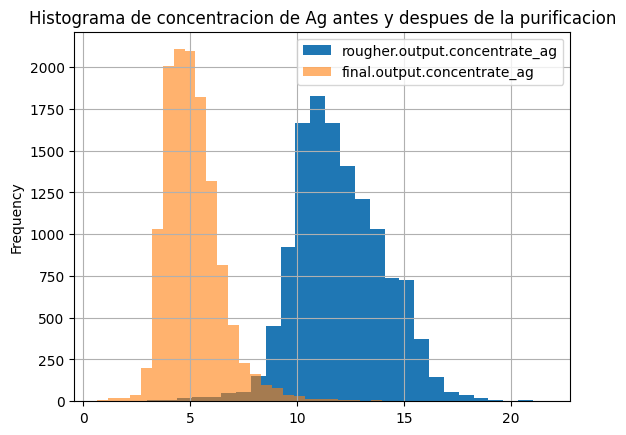

In [58]:
gold_recovery_train_no_missing_values["rougher.output.concentrate_ag"].plot(kind="hist",bins=30,legend=True,title="Histograma de concentracion de Ag antes y despues de la purificacion")
gold_recovery_train_no_missing_values["final.output.concentrate_ag"].plot(kind="hist",bins=30,alpha=0.6,grid=True,legend=True)
plt.show()

Pb

--------------------------------------------------------------------------------------------------------------------

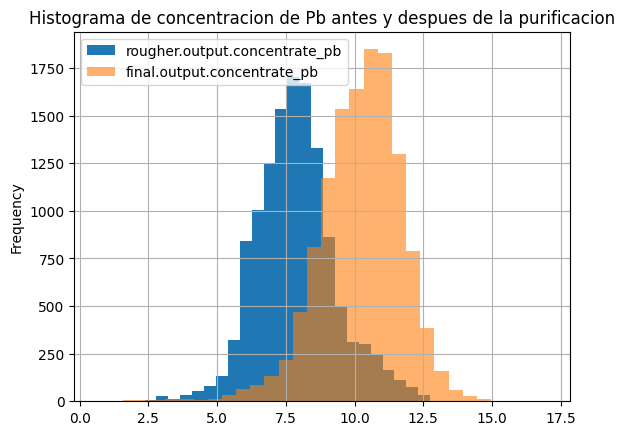

In [59]:
gold_recovery_train_no_missing_values["rougher.output.concentrate_pb"].plot(kind="hist",bins=30,legend=True,title="Histograma de concentracion de Pb antes y despues de la purificacion")
gold_recovery_train_no_missing_values["final.output.concentrate_pb"].plot(kind="hist",bins=30,alpha=0.6,grid=True,legend=True)
plt.show()

# HALLAZGOS

- Au

Se evidencia un aumento significativo en su concentracion despues de la purificacion, enfocada en la obtencio del oro.

- Ag

Se evidencia una disminucion en su concentracion.

- Pb

Se evidencia un aumento en su concentracion. Sin embargo, no es tan sigificativa como el oro.

La filtracion es efectiva para el mineral principal que es el oro, el cual se puede evidenciar en la distribucion de sus concentraciones, donde su media aumento.

# 2.2. Compara las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba. Si las distribuciones varían significativamente, la evaluación del modelo no será correcta.

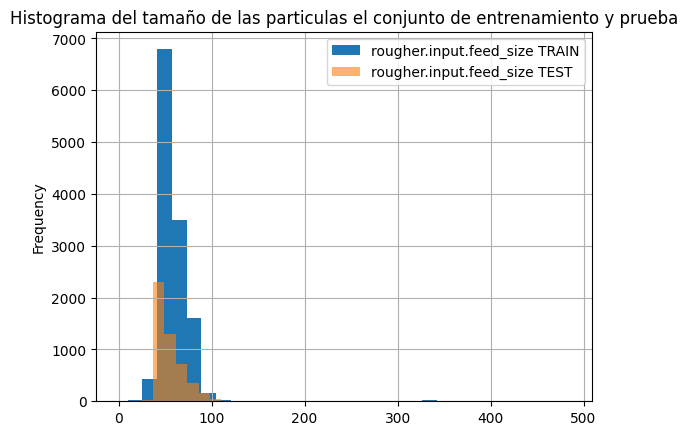

In [60]:
gold_recovery_train_no_missing_values["rougher.input.feed_size"].plot(kind="hist",bins=30,title="Histograma del tamaño de las particulas el conjunto de entrenamiento y prueba")
gold_recovery_test_full["rougher.input.feed_size_x"].plot(kind="hist",bins=30,alpha=0.6,grid=True)
labels=["rougher.input.feed_size TRAIN","rougher.input.feed_size TEST"]
plt.legend(labels)
plt.show()

- Verificacion de las distribuciones

In [66]:
print("Tamaño de particula en la alimentacion, conjunto de entrenamiento")
gold_recovery_train_no_missing_values["rougher.input.feed_size"].describe()

Tamaño de particula en la alimentacion, conjunto de entrenamiento


count    12620.000000
mean        59.253038
std         21.330880
min          9.659576
25%         48.979193
50%         55.258536
75%         64.926494
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [67]:
print("Tamaño de particula en la alimentacion, conjunto de prueba")
gold_recovery_test_full["rougher.input.feed_size_x"].describe()

Tamaño de particula en la alimentacion, conjunto de prueba


count    4933.000000
mean       55.886079
std        18.258523
min         0.046369
25%        43.845498
50%        50.694580
75%        62.520715
max       368.035882
Name: rougher.input.feed_size_x, dtype: float64

- Hipotesis de igualdad entre dos poblaciones

H0 no hay diferencia en el tamaño de particula entre el conjunto de entrenamiento y el de prueba.

H1 Si hay diferencia en el tamaño de particula.

In [23]:
# Prueba de levene para verificar la igualdad de varianzas-----------------------------------------------------------
result=st.levene(gold_recovery_test_full["rougher.input.feed_size_x"],gold_recovery_train_no_missing_values["rougher.input.feed_size"])
print("Prueba de Levene:")
print('valor p levene test: ', result.pvalue)
print("Statistic value= ",result.statistic)
alpha=0.05
if result.pvalue < alpha:
    print("Rechazamos la hipótesis nula","---- ","equal_var= False","\n")
else:
    print("No podemos rechazar la hipótesis nula","----- ","equal_var= True","\n")


# Verificacion de igualdad de medias entre 2 distribuciones----------------------------------------------------------
alpha = 0.05
results = st.ttest_ind(gold_recovery_test_full["rougher.input.feed_size_x"],gold_recovery_train_no_missing_values["rougher.input.feed_size"],equal_var= False)

print('valor p: ', results.pvalue) # extraer el valor p

if results.pvalue < alpha: # comparar el valor p con el umbral
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

Prueba de Levene:
valor p levene test:  0.009094396690540501
Statistic value=  6.805707607940417
Rechazamos la hipótesis nula ----  equal_var= False 

valor p:  1.7827649441896125e-25
Rechazamos la hipótesis nula


# HALLAZGOS:

Al verificar el tamaño de particula de alimentacion en el conjunto de entrenamiento y test desde diferentes angulos se evidencia:

1) En el histograma las variacion entre los valores de las distribuciones no es significativa.


2) Al calcular manualmente valores de promedio, mediana, min, max y varianza.

Promedio train:  59.25303837773885 -- Promedio test:  55.886079422565324

Mediana train:  55.25853554509831 -- Mediana test:  50.69458035017644

Valor maximo train:  484.9674664939735 -- Valor maximo test:  368.0358824536935

Valor minimo train:  9.659576314610517 -- Valor minimo test:  0.0463687988171973

Varianza train:  455.00645109597775 -- Varianza test:  333.3736680929642

Se evidencia que los valores de media y mediana son similares. Sin embargo, min, max y varianza varian significativamente.


3) Se realizo una prueba de hipotesis de diferencia de medias donde:

H0 no hay diferencia en el tamaño de particula entre el conjunto de entrenamiento y el de prueba.

H1 Si hay diferencia en el tamaño de particula.

Segun la prueba, se rechaza H0 y no se podria evaluar correctamente el modelo. Sin embargo, se utilizaran ambos conjuntos de prueba, ya que fueron dados inicialmente en el proyecto.

# 2.3. Considera las concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final. ¿Observas algún valor anormal en la distribución total? Si es así, ¿merece la pena eliminar esos valores de ambas muestras? Describe los resultados y elimina las anomalías.

- MATERIA PRIMA
---------------------------------------------------------------------------------------------------

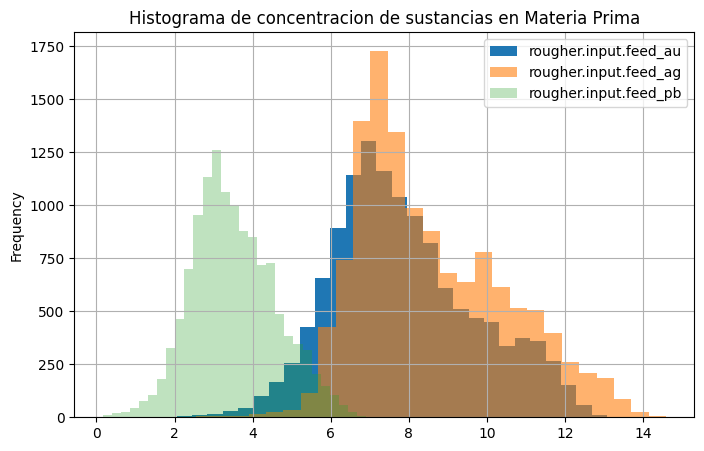

In [24]:
# Au
gold_recovery_train_no_missing_values["rougher.input.feed_au"].plot(kind="hist",bins=30,legend=True,title="Histograma de concentracion de sustancias en Materia Prima")
# Ag
gold_recovery_train_no_missing_values["rougher.input.feed_ag"].plot(kind="hist",bins=30,alpha=0.6,legend=True)
# Pb
gold_recovery_train_no_missing_values["rougher.input.feed_pb"].plot(kind="hist",bins=30,figsize=[8,5],alpha=0.3,grid=True,legend=True)
plt.show()

<AxesSubplot:>

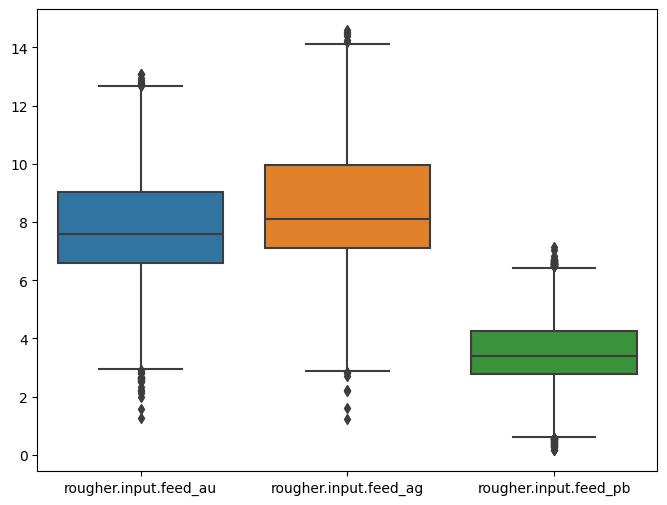

In [25]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=gold_recovery_train_no_missing_values[["rougher.input.feed_au","rougher.input.feed_ag","rougher.input.feed_pb"]])

- Concentrado rougher
---------------------------------------------------------------------------------------------------

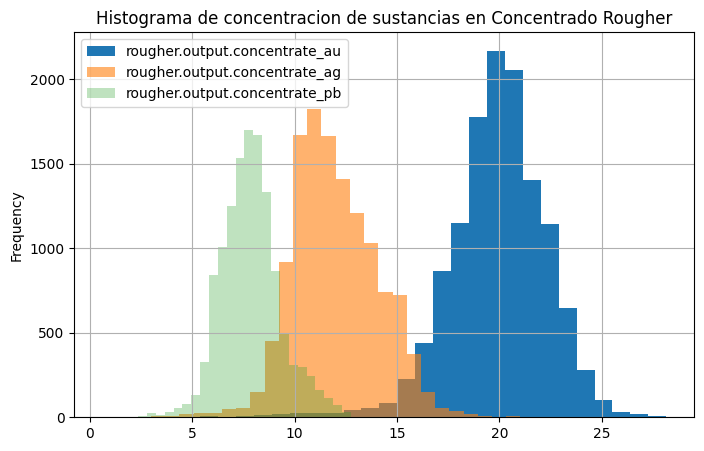

In [26]:
# Au
gold_recovery_train_no_missing_values["rougher.output.concentrate_au"].plot(kind="hist",bins=30,legend=True,title="Histograma de concentracion de sustancias en Concentrado Rougher")
# Ag
gold_recovery_train_no_missing_values["rougher.output.concentrate_ag"].plot(kind="hist",bins=30,alpha=0.6,legend=True)
# Pb
gold_recovery_train_no_missing_values["rougher.output.concentrate_pb"].plot(kind="hist",bins=30,figsize=[8,5],alpha=0.3,grid=True,legend=True)
plt.show()

<AxesSubplot:>

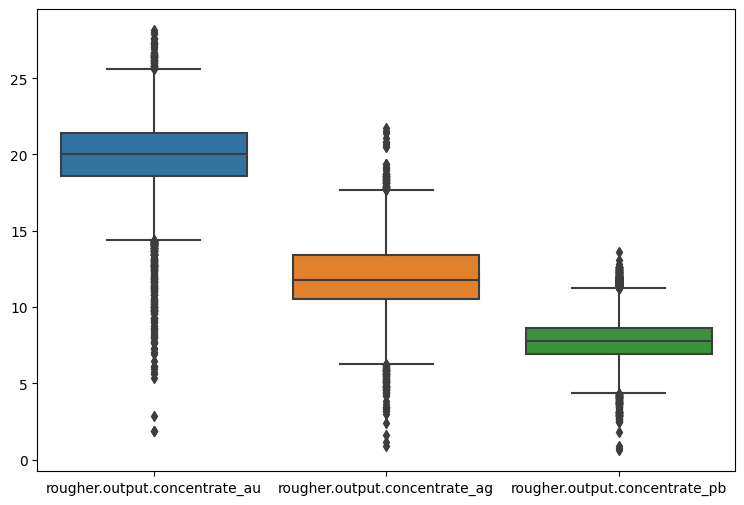

In [27]:
plt.figure(figsize=(9, 6))
sns.boxplot(data=gold_recovery_train_no_missing_values[["rougher.output.concentrate_au","rougher.output.concentrate_ag","rougher.output.concentrate_pb"]])

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Bien, este nivel de concentración se estudió adecuadamente.
</div>

- Concentrado final
---------------------------------------------------------------------------------------------------

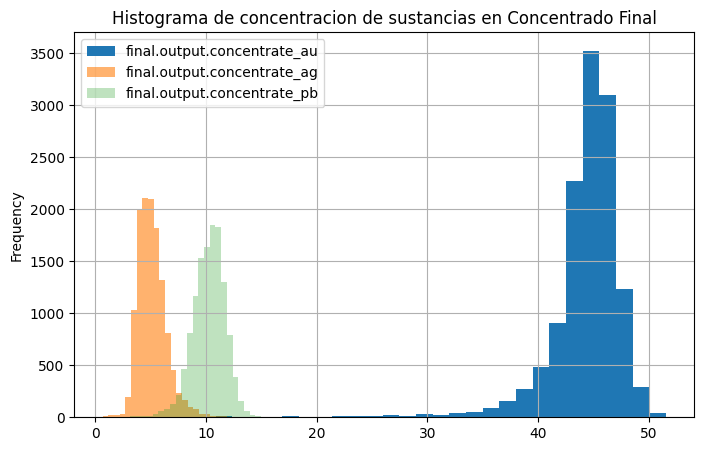

In [28]:
# Au
gold_recovery_train_no_missing_values["final.output.concentrate_au"].plot(kind="hist",bins=30,legend=True,title="Histograma de concentracion de sustancias en Concentrado Final")
# Ag
gold_recovery_train_no_missing_values["final.output.concentrate_ag"].plot(kind="hist",bins=30,alpha=0.6,legend=True)
# Pb
gold_recovery_train_no_missing_values["final.output.concentrate_pb"].plot(kind="hist",bins=30,figsize=[8,5],alpha=0.3,grid=True,legend=True)
plt.show()

<AxesSubplot:>

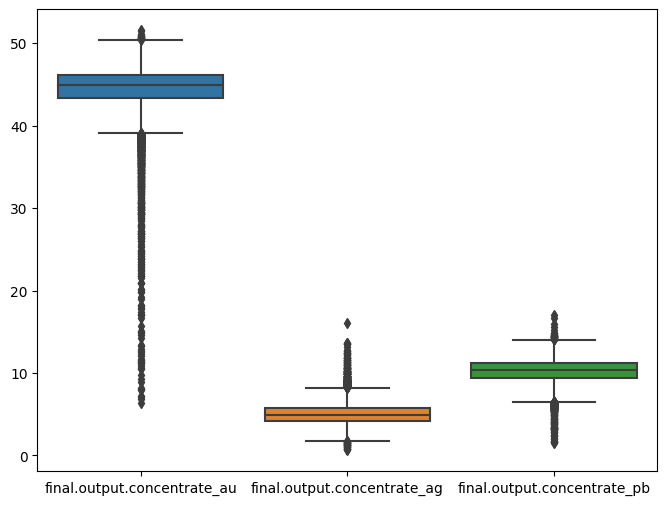

In [29]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=gold_recovery_train_no_missing_values[["final.output.concentrate_au","final.output.concentrate_ag","final.output.concentrate_pb"]])

HALLAZGOS:

Verificando las distribuciones, se puede evidenciar que las concentraciones de los metales en cada etapa poseen valores atipicos tanto inferiores como superiores y asi mismo la concentracion de oro es la distribucion con mayor numero de valores atipicos. Si se llegara a eliminar los valores atipicos de cualquiera de estas distribuciones, se corre el riesgo de eliminar datos importantes que se encuentren dentro de Q3 Y Q1.

Las distribuciones corresponden a la etapa en que se encuentran:

1) Mineral en bruto con la concentracion inicial de todos los metales.

2) Flotacion, en donde la concentracion de los metales aumenta debido a este proceso de separacion, no solo el oro es separado en esta etapa.

3) Purificacion, en el cual se utilizan tecnicas de purificacion enfocadas en la extraccion de oro, provocando un aumento considerable en la extraccion de oro con respecto a los otros metales. 

# 3. Construye el modelo

# 3.1. Escribe una función para calcular el valor final de sMAPE.

In [30]:
def val_smape(target_rougher_output,prediction_rougher_output,target_final_output,prediction_final_output):
    
    #rougher.output.recovery
    temp_smape_rougher_output=0
    for i in range(len(target_rougher_output)):
        temp_smape_rougher_output += ((abs(target_rougher_output[i] - prediction_rougher_output[i])) / ((abs(target_rougher_output[i]) + abs(prediction_rougher_output[i]))/2))*100
    
    smape_rougher_output  = (1/len(target_rougher_output))*temp_smape_rougher_output            
    
    #final.output.recovery
    temp_smape_final_output=0
    for i in range(len(target_final_output)):
        temp_smape_final_output += ((abs(target_final_output[i]-prediction_final_output[i]))/((abs(target_final_output[i])+abs(prediction_final_output[i]))/2))*100
    
    smape_final_output= (1/len(target_final_output))*temp_smape_final_output
    
    smape_final= ((0.25*smape_rougher_output)+(0.75*smape_final_output))
                               
    return smape_final

# 3.2 Entrena diferentes modelos. Evalúalos aplicando la validación cruzada. Elige el mejor modelo y pruébalo utilizando la muestra de prueba. Facilita los resultados.

3.2.1 Separacion de los conjuntos de datos y ultimas verificaciones.

Separacion de los conjuntos de datos de entrenamiento en:

- features_train

- target_train

In [31]:
features_train= gold_recovery_train_no_missing_values.drop(["date","rougher.output.recovery","final.output.recovery"],axis=1)
target_train= gold_recovery_train_no_missing_values[["rougher.output.recovery","final.output.recovery"]]

Separacion de los conjuntos de datos de prueba en:

- features_test

- target_test

El conjunto de datos de prueba poseen 4 columnas duplicadas con (y) al final debido al merge con el dataset full, estas columnas seran eliminadas

In [32]:
gold_recovery_test_full.drop(["rougher.input.feed_ag_y","rougher.input.feed_pb_y","rougher.input.feed_size_y","rougher.input.feed_au_y"],axis=1,inplace=True)

El nombre de las columnas con (x) al final, sera corregido.

In [33]:
new_cols=[]
for col in gold_recovery_test_full.columns:
    if col=="rougher.input.feed_ag_x":
        new_cols.append("rougher.input.feed_ag")
    elif col == "rougher.input.feed_pb_x":
        new_cols.append("rougher.input.feed_pb")
    elif col == "rougher.input.feed_size_x":
        new_cols.append("rougher.input.feed_size")
    elif col == "rougher.input.feed_au_x":
        new_cols.append("rougher.input.feed_au")
    else:
        new_cols.append(col)
gold_recovery_test_full.columns=new_cols

Separacion de los conjuntos.

In [34]:
features_test= gold_recovery_test_full.drop(["date","rougher.output.recovery","final.output.recovery"],axis=1)
target_test= gold_recovery_test_full[["rougher.output.recovery","final.output.recovery"]]

3.2.2 Creacion de distintos modelos y evaluacion mediante la validacion cruzada en 5 grupos para predecir las columnas requeridas:

"rougher.output.recovery"

"final.output.recovery"

- Decision Tree Regressor

In [35]:
best_depth=0
best_score=0
for depth in range(1,20):
    model=DecisionTreeRegressor(random_state=12345,max_depth=depth)
    scores= cross_val_score(model,features_train,target_train,cv=5)
    final_score= scores.mean()
    if final_score>best_score:
        best_score= final_score
        best_depth=depth
    
print(f"Puntuacion maxima media de evaluacion del modelo Decision Tree Regressor {best_score} obtenida con un depth de: {best_depth}")

Puntuacion maxima media de evaluacion del modelo Decision Tree Regressor 0.06907606517248366 obtenida con un depth de: 19


- Random Forest Regressor

In [36]:
'''
%%time
best_depth=0
best_score=0
best_est=0

for depth in range(1,20):
    for est in range(1,51,10):
        model=RandomForestRegressor(random_state=12345,max_depth=depth,n_estimators=est)
        scores= cross_val_score(model,features_train,target_train,cv=5)
        final_score= scores.mean()
        if final_score>best_score:
            best_score= final_score
            best_depth=depth
            best_est=est
        print(f"final_score {final_score}  depth {depth}  est {est}")
    
print(f"Puntuacion maxima media de evaluacion del modelo Random Forest Regressor {best_score} obtenida con un depth: {best_depth} y n: {best_est}")
'''

'\n%%time\nbest_depth=0\nbest_score=0\nbest_est=0\n\nfor depth in range(1,20):\n    for est in range(1,51,10):\n        model=RandomForestRegressor(random_state=12345,max_depth=depth,n_estimators=est)\n        scores= cross_val_score(model,features_train,target_train,cv=5)\n        final_score= scores.mean()\n        if final_score>best_score:\n            best_score= final_score\n            best_depth=depth\n            best_est=est\n        print(f"final_score {final_score}  depth {depth}  est {est}")\n    \nprint(f"Puntuacion maxima media de evaluacion del modelo Random Forest Regressor {best_score} obtenida con un depth: {best_depth} y n: {best_est}")\n'

Puntuacion maxima media de evaluacion del modelo Random Forest Regressor: 0.4529749781103794 obtenida con un depth: 16 y n: 30

La ejecucuion del codigo Random Forest Regressor genera un alto consumo de recursos y un largo tiempo de respuesta, por este motivo, se agrego la respuesta manualmente y el codigo se dejo en comentario.

- Linear Regression

In [37]:
model=LinearRegression()
scores= cross_val_score(model,features_train,target_train,cv=5)
final_score= scores.mean()
print(f"Puntuacion maxima media de evaluacion del modelo Linear Regressor {final_score}")

Puntuacion maxima media de evaluacion del modelo Linear Regressor 0.5475209850764642


---------------------------------------------------------------------------------------------------

Acorde al score resultante el mejor modelo para la obtencion de "rougher.output.recovery" y "final.output.recovery" es Linear Regression. Sin embargo, al realizar el calculo del sMAPE, utilizando los mejores hiperparametros obtenidos anteriormente en Random Forest Regressor (depth: 16, n: 30), el valor de esta metrica es menor.


---------------------------------------------------------------------------------------------------

3.2.3 Prueba del modelo con los datos de prueba:

In [38]:
model=RandomForestRegressor(random_state=12345,max_depth=16,n_estimators=30)
model.fit(features_train,target_train)
output_recovery_prediction= model.predict(features_test)

target_test_rougher= target_test["rougher.output.recovery"]
rougher_output_recovery_prediction= output_recovery_prediction[:,0]
target_test_final= target_test["final.output.recovery"]
final_output_recovery_prediction= output_recovery_prediction[:,1]

3.2.4 Calculo del sMAPE final

In [39]:
smape_final= val_smape(target_test_rougher,rougher_output_recovery_prediction,target_test_final,final_output_recovery_prediction)
print(f"Valor sMAPE final:  {smape_final} %")

Valor sMAPE final:  13.268293087171468 %


# 4 CONCLUSIONES








Despues de realizar el preprocesamiento, analisis y creacion del modelo con los datos de extraccion de mineral. Se obtuvo un sMAPE (Error porcentual absoluto medio simétrico) de: 13.268293087171468 %, lo que significa que nuestros modelos de machine learning presentan una menor diferencia porcentual entre los valores predichos y los reales. Es decir, su fiabilidad al momento de predecir datos es alta.